<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.index.is_monotonic

True

In [7]:
data = data.resample('1H').sum()

In [8]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [9]:
decomposed = seasonal_decompose(data)

## Анализ

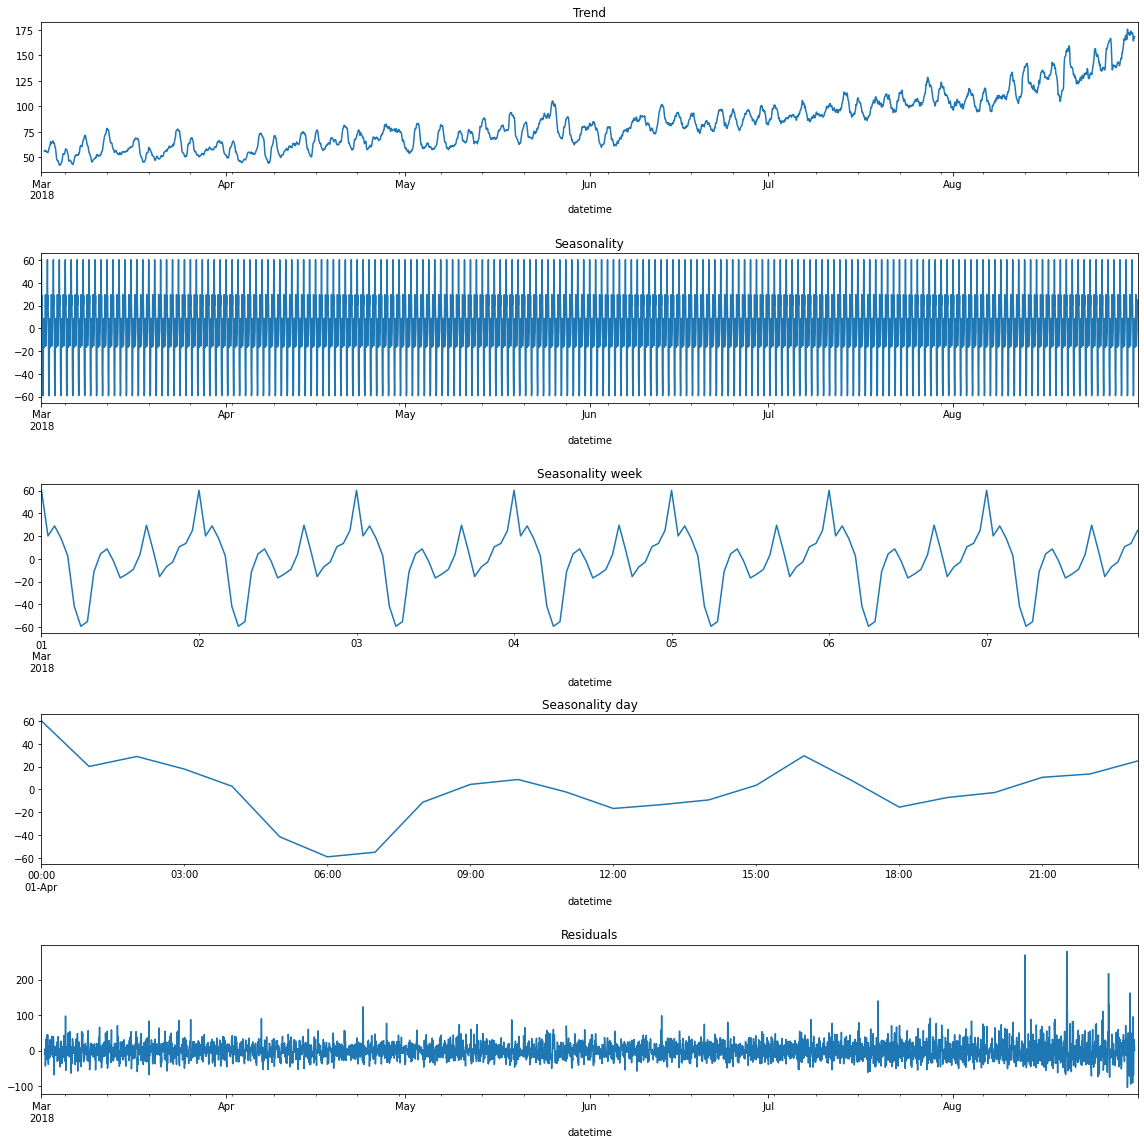

In [10]:
plt.figure(figsize=(16, 16))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(513)
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())
plt.title('Seasonality week')
plt.subplot(514)
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-1 23:00:00'].plot(ax=plt.gca())
plt.title('Seasonality day')
plt.subplot(515)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

* Видим плавный восходящий тренд на протяжении полугода
* Судя по ежедневной сезонности, минимальное колиество вызовов такси наблюдается в 6 утра, пик - 12 ночи. 
* Разницы по дням недели особо не наблюдается, на протяжении всей недели сохраняется ежедневная сезонность. 

Создадим признаки (час, день недели и выходные) для дальнейшего обучения моделей

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['hours'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['weekend'] = data.index.dayofweek.isin([5,6])
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)

    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    return data

In [12]:
make_features(data, 24, 12)

,num_orders,hours,dayofweek,weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,False,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,False,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,False,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,False,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,False,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,163.416667
2018-08-31 20:00:00,154,20,4,False,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.916667
2018-08-31 21:00:00,159,21,4,False,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.583333


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   hours         4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   weekend       4416 non-null   bool   
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

## Обучение

Разделим выборки на обучающую и тестовую(10%)

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

In [16]:
models_score = pd.DataFrame(columns = ['MODEL', 'RMSE'])

Обучим модели LinearRegression и CatBoostRegressor, подберём гиперпараметры и узнаем их RMSE на обучающей выборке

In [17]:
model = LinearRegression()

# Вычисление кросс-валидационного RMSE на тестовых данных
rmse_scores = np.sqrt(-cross_val_score(model, features_test, target_test, scoring='neg_mean_squared_error', cv=5))

# Вывод среднего и стандартного отклонения RMSE
print('Средний RMSE по кросс-валидации на тестовых данных:', np.mean(rmse_scores))
print('Стандартное отклонение RMSE по кросс-валидации на тестовых данных:', np.std(rmse_scores))
models_score = models_score.append({'MODEL' : 'LinearRegression',
                     'RMSE' : np.mean(rmse_scores)}, ignore_index=True)

Средний RMSE по кросс-валидации на тестовых данных: 45.02696947437947
Стандартное отклонение RMSE по кросс-валидации на тестовых данных: 5.310622315594794


In [18]:
cat_features = ['hours', 'dayofweek', 'weekend']

In [19]:
%%time
# Создание модели CatBoostRegressor
model = CatBoostRegressor(verbose=False)

# Задание пространства параметров для автоматического поиска
param_search = {
    'iterations': [100, 230, 360],
    'learning_rate': [0.1],
    'depth': [3, 6, 9]
}

# Создание объекта TimeSeriesSplit для кросс-валидации
tscv = TimeSeriesSplit(n_splits=5)

# Создание объекта GridSearchCV для автоматического поиска гиперпараметров с использованием TimeSeriesSplit
grid_search = GridSearchCV(estimator=model, param_grid=param_search, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=-1)

model.get_params().keys()

grid_search.fit(features_train, target_train, cat_features=cat_features)

# Получение лучших гиперпараметров и соответствующего качества модели по кросс-валидации
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Обучение модели на тренировочных данных с лучшими гиперпараметрами
best_model = grid_search.best_estimator_
best_model.fit(features_train, target_train, cat_features=cat_features)

# Предсказание на тестовой выборке
predictions_test = best_model.predict(features_test)

# Вычисление RMSE модели на тестовой выборке
rmse_test = np.sqrt(mean_squared_error(target_test, predictions_test))

# Вывод результатов
print('Лучшие гиперпараметры:', best_params)
print('RMSE модели на тестовой выборке:', rmse_test)
print('Качество модели по кросс-валидации:', best_score)
models_score = models_score.append({'MODEL': 'CatBoostRegressor',
                                    'RMSE': rmse_test}, ignore_index=True)

Лучшие гиперпараметры: {'depth': 6, 'iterations': 360, 'learning_rate': 0.1}
RMSE модели на тестовой выборке: 40.243857260775094
Качество модели по кросс-валидации: -585.302032045473
CPU times: user 2min 27s, sys: 49.9 s, total: 3min 17s
Wall time: 3min 51s


In [20]:
models_score

,MODEL,RMSE
0,LinearRegression,45.026969
1,CatBoostRegressor,40.243857


Как видим, модель CatBoostRegressor справляется с задачей лучше 

## Тестирование

Протестируем модели и узнаем их RMSE на тестовой выборке

In [21]:
models_score_test = pd.DataFrame(columns = ['MODEL', 'RMSE'])

In [22]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('RMSE:', np.sqrt(mean_squared_error(target_test, predictions)))
models_score_test = models_score_test.append({'MODEL' : 'LinearRegression',
                     'RMSE' : np.sqrt(mean_squared_error(target_test, predictions))}, 
                                   ignore_index=True)

RMSE: 45.121377318787076


In [23]:
%%time
# Создание модели CatBoostRegressor
model = CatBoostRegressor(learning_rate=0.1, iterations=360, depth=6, verbose=90)

model.fit(features_train, target_train, cat_features=cat_features)

# Предсказание на тестовом наборе
predictions = model.predict(features_test)

# Вычисление RMSE модели на тестовом наборе
rmse_test = np.sqrt(mean_squared_error(target_test, predictions))

# Вывод результатов
print('RMSE модели на тестовом наборе:', rmse_test)
models_score_test = models_score_test.append({'MODEL' : 'CatBoostRegressor',
                     'RMSE' : np.sqrt(mean_squared_error(target_test, predictions))}, 
                                   ignore_index=True)

0:	learn: 37.0521238	total: 11.7ms	remaining: 4.19s
90:	learn: 20.0237011	total: 710ms	remaining: 2.1s
180:	learn: 17.5694772	total: 1.52s	remaining: 1.5s
270:	learn: 15.7944794	total: 2.38s	remaining: 781ms
359:	learn: 14.2617014	total: 3.25s	remaining: 0us
RMSE модели на тестовом наборе: 40.243857260775094
CPU times: user 3.3 s, sys: 134 ms, total: 3.43 s
Wall time: 4.27 s


In [24]:
models_score_test

,MODEL,RMSE
0,LinearRegression,45.121377
1,CatBoostRegressor,40.243857


In [25]:
# Создание базовой модели
baseline_predictions = target_test.shift()
baseline_predictions.iloc[0] = target_train.iloc[-1]

# Вычисление RMSE базовой модели
baseline_rmse = np.sqrt(mean_squared_error(target_test, baseline_predictions))

# Вывод результатов
print('RMSE базовой модели:', baseline_rmse)

# Сравнение с моделью CatBoostRegressor
if rmse_test < baseline_rmse:
    print('Модель CatBoostRegressor прошла проверку на адекватность 🙌')
else:
    print('Модель CatBoostRegressor не прошла проверку на адекватность!')


RMSE базовой модели: 58.856486242815066
Модель CatBoostRegressor прошла проверку на адекватность 🙌


Делаем вывод, что оптимальной моделью для данной задачи является CatBoostRegressor

Сравним целевые значения с предсказанными моделью CatBoostRegressor

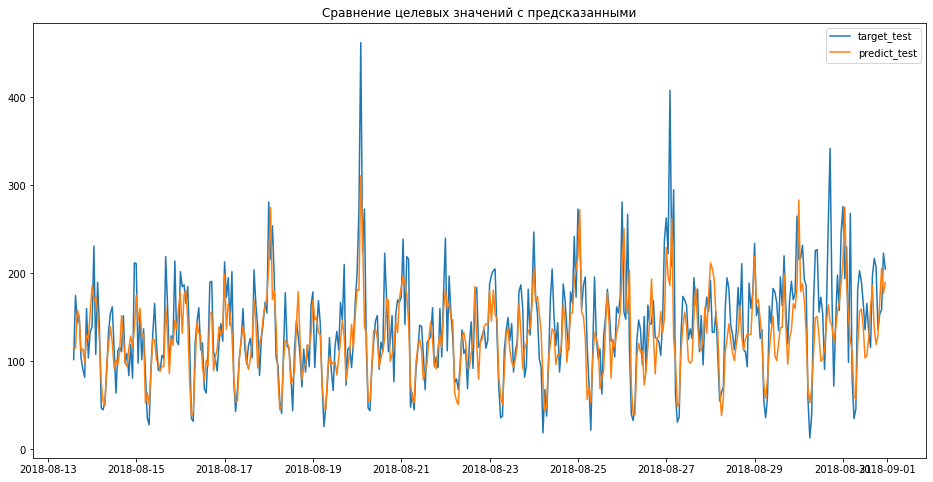

In [26]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='target_test')
plt.plot(target_test.index, predictions_test, label='predict_test')

plt.title('Сравнение целевых значений с предсказанными')
plt.legend()
plt.show()

По графику наблюдаем следующее: модель ошибается чаще на высоких значениях, нежели низких и средних

# Вывод:
Значение метрики RMSE модели CatBoostRegressor на тестовой выборке  составляет 40, что являтеся подходящим для данной задачи. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48